In [1]:
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

2023-08-08 18:07:59.441556: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 18:07:59.490240: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 18:07:59.491256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 18:08:00.379693: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
def label_transfer(adata, train_species, test_species):

    sc.pp.pca(adata, n_comps=15) #may want to update n_comps to encompass ~90% of data's variation
    #np.sum(adata.uns['pca']['variance_ratio']) #check what % of variation due to PCs?

    #make dataframe with PCs, reference labels, species labels
    pc_df = pd.DataFrame(adata.obsm['X_pca'])
    pc_df = pc_df.set_index(adata.obs.index)
    final_df = pd.concat([pc_df, adata.obs['ref_labels'], adata.obs['species']], axis = 1)

    #convert cell type labels to numerical values used by model
    y = final_df["ref_labels"]
    labelencoder = LabelEncoder()
    final_Y = labelencoder.fit_transform(y)
    final_df["category"] = final_Y

    #separate df into species-specific dfs
    df_train = final_df[final_df['species'] == train_species]
    df_test = final_df[final_df['species'] == test_species]
    df_train = df_train.drop(labels=["species"], axis=1)
    df_test = df_test.drop(labels=["species"], axis=1)
    
    #break into training and testing data
    X_train = df_train.drop(labels=["ref_labels", "category"], axis=1)
    Y_train = df_train["category"]
    X_test = df_test.drop(labels=["ref_labels", "category"], axis=1)
    Y_test = df_test["category"]
    
    #Define XGB classifier
    bst = XGBClassifier(learning_rate = 0.1,
     n_estimators=1000,
     max_depth=4,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     seed=27)
    
    # fit model
    bst.fit(X_train, Y_train)
    # make predictions
    preds = bst.predict(X_test)
    
    #print accuracy rating
    print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (Y_test != preds).sum()))
    
    #generate plots, note that cell type labels should be in column "ref_labels" (contrary to this example). 
    preds = labelencoder.inverse_transform(preds)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    data = adata[adata.obs['species'] == test_species]
    sc.pl.umap(data, color="ref_labels", title=test_species + " by Actual CT")
    data.obs["predicted"] = preds
    sc.pl.umap(data, color="predicted", title=test_species + " by Predicted CT")

Number of mislabeled points out of a total 3119 points : 1792


/opt/conda/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


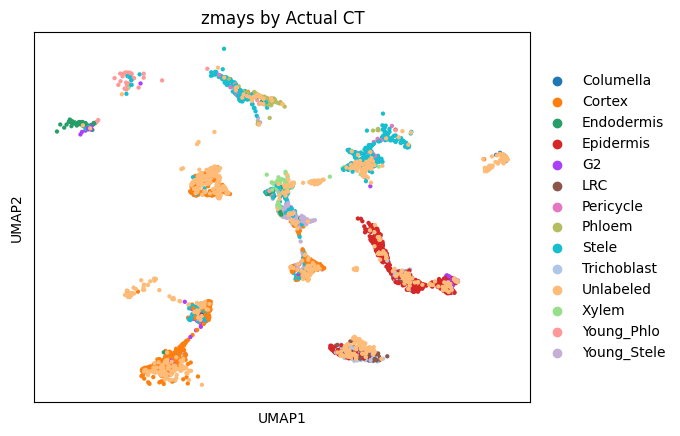

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


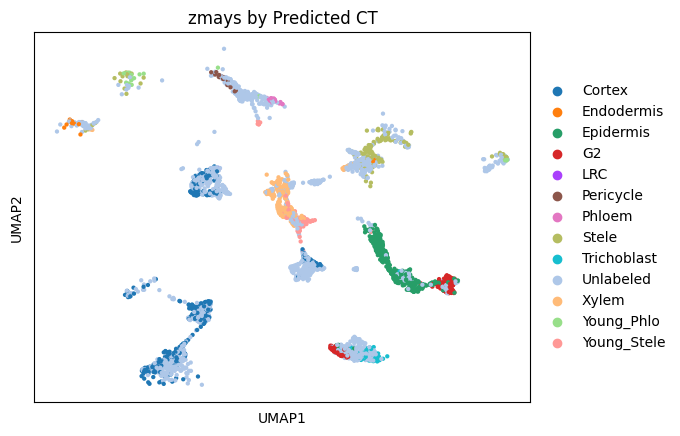

In [14]:
#UPDATE PATH to SATURN output file, training and testing species (species names correspond to names in results adata object)
adata = sc.read("/home/apennacchio/pcsct/saturn/out/in_leid_ref_CT_no_subtype/test256_data_sbicolor_root10_zmays_root1_org_saturn_seed_0.h5ad")
train_species = "sorghum"
test_species = "zmays"

label_transfer(adata, train_species, test_species)
